In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import glob
from sklearn.feature_selection import mutual_info_classif as MIC
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
import time

In [2]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.ensemble import RandomForestClassifier

In [3]:
# number = int(get_ipython().user_ns['param'])
number = 2

In [4]:
model_acc=[]
model_precision=[]
model_recal=[]
model_f1=[]
model_nam=[]
model_confusion=[]
model_time=[]
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report,f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
df = pd.read_csv('../Dataset CSV/csv_result-data'+str(number)+' Sampled Scenarios.csv')

In [6]:
# Feature construction
df['R1-VCM1'] = (df['R1-PM1:V'] - df['R1-PM7:V']) / (df['R1-PM4:I'] - df['R1-PM10:I'])
df['R3-sV1'] = np.sin(df['R3-PA1:VH'] - df['R3-PA7:VH'])
df['R3-sV3'] = np.sin(df['R3-PA3:VH'] - df['R3-PA9:VH'])
df['R2-VCM1'] = (df['R2-PM1:V'] - df['R2-PM7:V']) / (df['R2-PM4:I'] - df['R2-PM10:I'])
df['R3-VCM1'] = (df['R3-PM1:V'] - df['R3-PM7:V']) / (df['R3-PM4:I'] - df['R3-PM10:I'])
df['R4-sI1'] = np.sin(df['R4-PA4:IH'] - df['R4-PA10:IH'])
df['R2-VCA4'] = df['R2-PA7:VH'] - df['R2-PA10:IH']
df['R1-sI1'] = np.sin(df['R1-PA4:IH'] - df['R1-PA10:IH'])
df['R4-VCM2'] = (df['R4-PM2:V'] - df['R4-PM8:V']) / (df['R4-PM5:I'] - df['R4-PM11:I'])
df['R2-VCA1'] = np.sin(df['R2-PA1:VH'] - df['R2-PA4:IH'] - df['R2-PA7:VH'] - df['R2-PA10:IH'])
df['R3-VCM2'] = (df['R3-PM2:V'] - df['R3-PM8:V']) / (df['R3-PM5:I'] - df['R3-PM11:I'])
df['R1-VCA4'] = df['R1-PA7:VH'] - df['R1-PA10:IH']
df['R1-VCM2'] = (df['R1-PM2:V'] - df['R1-PM8:V']) / (df['R1-PM5:I'] - df['R1-PM11:I'])
df['R2-VCM2'] = (df['R2-PM2:V'] - df['R2-PM8:V']) / (df['R2-PM5:I'] - df['R2-PM11:I'])
df['R4-VCA4'] = df['R4-PA7:VH'] - df['R4-PA10:IH']
df['R4-VCM1'] = (df['R4-PM1:V'] - df['R4-PM7:V']) / (df['R4-PM4:I'] - df['R4-PM10:I'])

In [7]:
# add the marker to the last of the list
cols = list(df.columns)
cols.remove('marker')
df = df[cols + ['marker']]

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace= True)
df.isnull().sum().sum()

2937

In [9]:
df = df.fillna(value=df.mean())

In [10]:
print(df.isin([np.inf, -np.inf]).sum().sum(), df.isnull().sum().sum())

0 0


In [11]:
df_z_scaled = df.copy()
for column in df_z_scaled.columns:
#     print(df_z_scaled[column])
    if (df_z_scaled[column].std() != 0) and (column != 'id') and (column != 'marker'):
        df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()     
# print(df_z_scaled)

In [12]:
X = df_z_scaled.iloc[:,1:-1]
y = df_z_scaled.iloc[:,-1:]

In [13]:
# Label the marker data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y, columns=["marker"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [14]:
corr_matrix = X.corr(method ='pearson')
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

<ipython-input-14-1d22c40dcc8b>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [15]:
import xgboost as xgb

# Train the XGBoost model on the training data
model = xgb.XGBClassifier()
model.fit(X, y)

# Extract the feature importance scores
weights = model.get_booster().get_score(importance_type='weight')

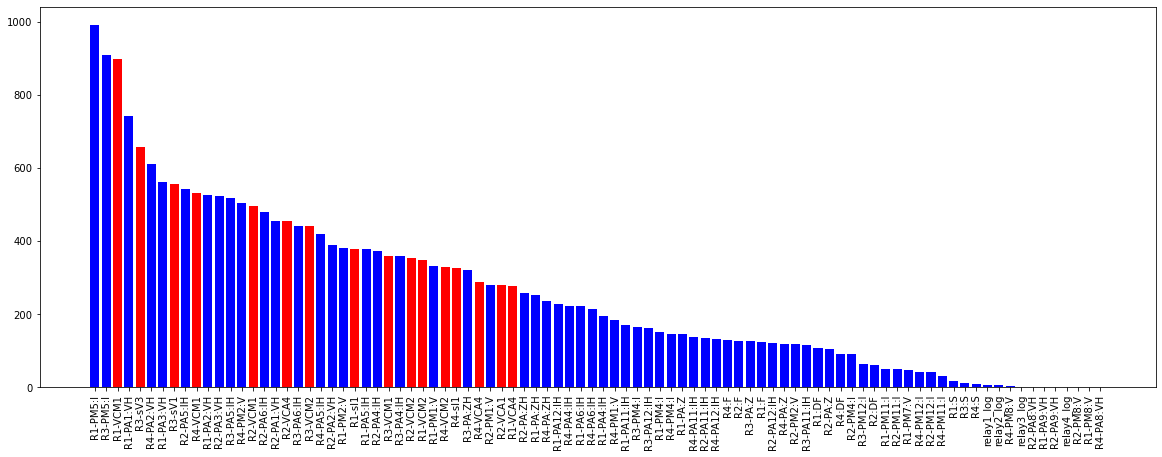

In [16]:
# Convert the dictionary to a pandas dataframe and add a column for the feature names
importance = pd.DataFrame(weights, index=['weight']).T
importance.reset_index(inplace=True)
importance.rename(columns={'index': 'feature'}, inplace=True)

# Sort the feature importance scores in descending order
importance.sort_values(by='weight', ascending=False, inplace=True)

# Plot the feature importance scores
plt.figure(figsize=(20,7))
colors = ['red' if f in ['R1-VCM1', 'R3-sV1' , 'R3-sV3', 'R2-VCM1', 'R3-VCM1', 'R4-sI1', 'R2-VCA4', 'R1-sI1', 'R4-VCM2', 'R2-VCA1', 'R3-VCM2', 'R1-VCA4', 'R1-VCM2', 'R2-VCM2', 'R4-VCA4', 'R4-VCM1'] else 'blue' for f in importance['feature']]

# Plot the bar chart
plt.bar(importance['feature'], importance['weight'], color=colors)
plt.xticks( importance['feature'], rotation=90)
plt.show()

In [17]:
top_n_feature_names = importance['feature'][:31].values
print(top_n_feature_names)

['R1-PM5:I' 'R3-PM5:I' 'R1-VCM1' 'R1-PA1:VH' 'R3-sV3' 'R4-PA2:VH'
 'R1-PA3:VH' 'R3-sV1' 'R2-PA5:IH' 'R4-VCM1' 'R1-PA2:VH' 'R2-PA3:VH'
 'R3-PA5:IH' 'R4-PM2:V' 'R2-VCM1' 'R2-PA6:IH' 'R2-PA1:VH' 'R2-VCA4'
 'R3-PA6:IH' 'R3-VCM2' 'R4-PA5:IH' 'R2-PA2:VH' 'R1-PM2:V' 'R1-sI1'
 'R1-PA5:IH' 'R2-PA4:IH' 'R3-VCM1' 'R3-PA4:IH' 'R2-VCM2' 'R1-VCM2'
 'R1-PM1:V']


In [18]:
importance['feature'].values

array(['R1-PM5:I', 'R3-PM5:I', 'R1-VCM1', 'R1-PA1:VH', 'R3-sV3',
       'R4-PA2:VH', 'R1-PA3:VH', 'R3-sV1', 'R2-PA5:IH', 'R4-VCM1',
       'R1-PA2:VH', 'R2-PA3:VH', 'R3-PA5:IH', 'R4-PM2:V', 'R2-VCM1',
       'R2-PA6:IH', 'R2-PA1:VH', 'R2-VCA4', 'R3-PA6:IH', 'R3-VCM2',
       'R4-PA5:IH', 'R2-PA2:VH', 'R1-PM2:V', 'R1-sI1', 'R1-PA5:IH',
       'R2-PA4:IH', 'R3-VCM1', 'R3-PA4:IH', 'R2-VCM2', 'R1-VCM2',
       'R1-PM1:V', 'R4-VCM2', 'R4-sI1', 'R3-PA:ZH', 'R4-VCA4', 'R2-PM1:V',
       'R2-VCA1', 'R1-VCA4', 'R2-PA:ZH', 'R1-PA:ZH', 'R4-PA:ZH',
       'R1-PA12:IH', 'R4-PA4:IH', 'R1-PA6:IH', 'R4-PA6:IH', 'R1-PA4:IH',
       'R4-PM1:V', 'R1-PA11:IH', 'R3-PM4:I', 'R3-PA12:IH', 'R1-PM4:I',
       'R4-PM4:I', 'R1-PA:Z', 'R4-PA11:IH', 'R2-PA11:IH', 'R4-PA12:IH',
       'R4:F', 'R2:F', 'R3-PA:Z', 'R1:F', 'R2-PA12:IH', 'R4-PA:Z',
       'R2-PM2:V', 'R3-PA11:IH', 'R1:DF', 'R2-PA:Z', 'R4:DF', 'R2-PM4:I',
       'R3-PM12:I', 'R2:DF', 'R1-PM11:I', 'R2-PM11:I', 'R1-PM7:V',
       'R4-PM12:I', 'R2-PM12:I', 